In [1]:
import os
import sys

import pickle

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import sklearn.preprocessing as skp

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
import arch.unitroot as au
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
py.init_notebook_mode(connected=True)

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from TCC_pkg import dataanalysis as da
from TCC_pkg import testspecification as tspec
from TCC_pkg import autoregressive as ar

## Load data

In [3]:
# coffee, dji, gold, ibov, nasdaq, real_peso, real_usd, sp500_fut
series_name = 'real_peso'
with open('../Data/{}.pkl'.format(series_name), 'rb') as f:
    df_raw = pickle.load(f)

## Initial summary of data

In [22]:
df = df_raw.copy()
print('Shape: {}\n'.format(df.shape))
print('Indices: \n{}\n{}\n'.format(df.index[:5], df.index[-5:]))
print('Columns: \n{}\n'.format(df.columns))
print('Describe(): \n{}\n'.format(df.describe()))

Shape: (1767, 2)

Indices: 
DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',
               '2011-01-07'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2018-05-23', '2018-05-24', '2018-05-28', '2018-05-29',
               '2018-05-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

Columns: 
Index(['Close', 'Direction'], dtype='object')

Describe(): 
             Close    Direction
count  1767.000000  1766.000000
mean      0.320083    -0.055493
std       0.092831     0.998742
min       0.145750    -1.000000
25%       0.219300    -1.000000
50%       0.341850    -1.000000
75%       0.404925     1.000000
max       0.477150     1.000000



## Plot data

In [5]:
df = df_raw
da.plotscatter(df=df[['Close']], name='{}'.format(series_name), title='{}'.format(series_name))

# <span style='color:crimson'>2.</span> Preprocessing

## <span style='color:MediumBlue'>2.1.</span> Adjusting values

In [6]:
# Adjust time-series
df = df_raw.copy()

# 1. Find zeros or negative values
print('Number of zero-values: {}'.format(df[df==0].count().values))

# 2. Find NaNs
print('Number of NaNs: {}'.format(df[df.isna().values].count().values))

# 3. Eliminate entries with NaNs
df = df.dropna(how='any', axis=0)

# 4. Gaps
date_gaps = np.array([(df.index[i]-df.index[i-1]).days for i in range(1,len(df.index))])
print('Average gap: {}'.format(date_gaps.mean()))
print('Max gap: {}'.format(date_gaps.max()))
print('No. of gaps greater than 5: {}'.format(len(date_gaps[date_gaps>5])))
print('15 greatest gaps: {}'.format(np.sort(date_gaps)[-15:]))
print('Dates of greatest gap: \n{}\n'.format(df.iloc[date_gaps.argmax()-1:date_gaps.argmax()+3]))

df_adj = df

Number of zero-values: [0 0]
Number of NaNs: [1 0]
Average gap: 1.5314447592067988
Max gap: 7
No. of gaps greater than 5: 5
15 greatest gaps: [5 5 5 5 5 5 5 5 5 5 6 6 6 6 7]
Dates of greatest gap: 
              Close  Direction
Date                          
2013-03-26  0.39235       -1.0
2013-03-27  0.39405        1.0
2013-04-03  0.39445        1.0
2013-04-04  0.39355       -1.0



## <span style='color:MediumBlue'>2.2.</span> Visual analysis

### Outliers

In [7]:
df = df_adj
ts = df_adj['Close']
n_std = 3

df = pd.concat([df, da.roll_stats(ts=ts, window=30)], axis=1).dropna(how='any',axis=0)
df['Upper'] = df['Rolling Mean'] + n_std*df['Rolling Variance'].apply(np.sqrt)
df['Lower'] = df['Rolling Mean'] - n_std*df['Rolling Variance'].apply(np.sqrt)

da.plotscatter(df.drop(columns='Direction'))

# Outlier criterion
df_out = df[(df['Close'] > df['Upper']) | (df['Close'] < df['Lower'])]
df['Out'] = df.loc[df_out.index, 'Close']

df = df.replace(np.nan, 0) # for plotting
da.plotscatter(df.drop(columns='Direction'))

df = df.drop(df_out.index)
df_adj_noout = df[['Close']]

### Stationarity tests

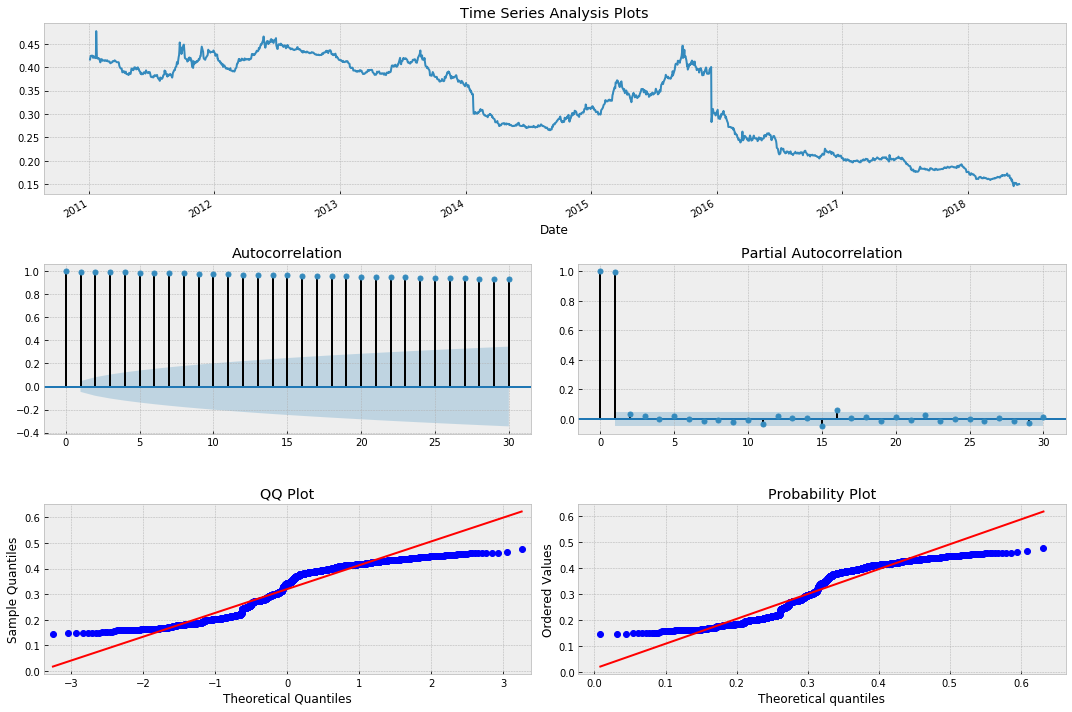

In [8]:
ts = df_adj['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [9]:
ts = df_adj['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.655
P-value                         0.858
Lags                               59
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.398
P-value                         0.911
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  5.567
P-value                         0.000
Lags                               2

## <span style='color:MediumBlue'>2.3.</span> Transformations

### <span style='color:Goldenrod'>2.3.1</span> Log-transform

In [10]:
df = df_adj[['Close']]

# Log-transform

df_log = pd.concat([df.applymap(np.log), df_adj[['Direction']]], axis=1)

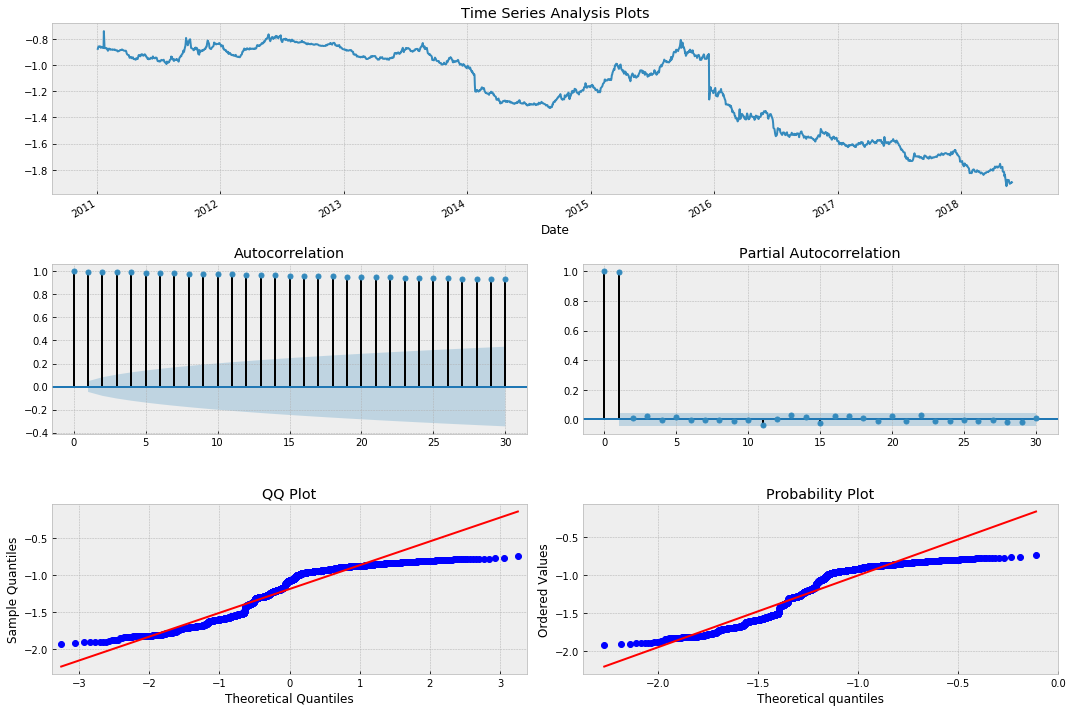

In [11]:
ts = df_log['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [12]:
ts = df_log['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                  0.017
P-value                         0.960
Lags                               59
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                  0.303
P-value                         0.977
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  5.580
P-value                         0.000
Lags                               2

### <span style='color:Goldenrod'>2.3.1</span> Differencing

In [13]:
df = df_log[['Close']]

df_log_diff = df_log.copy()
df_log_diff['Close'] = da.difference_ts(df=df)
df_log_diff = df_log_diff.dropna()

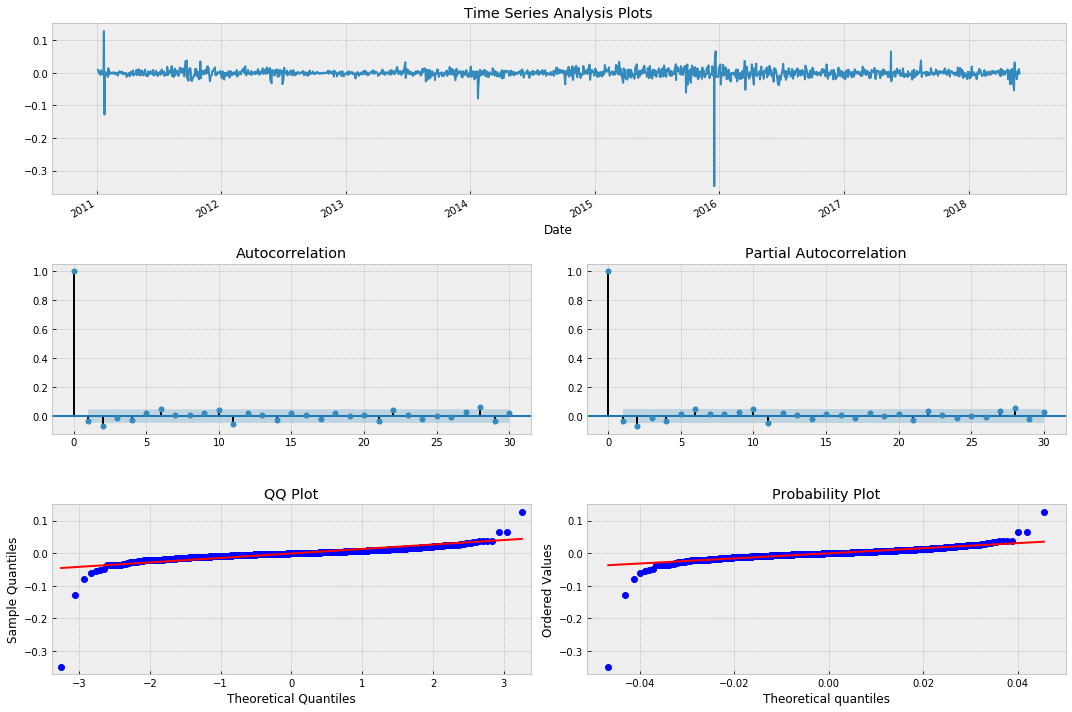

In [14]:
ts = df_log_diff['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(df_log_diff[['Close']])
da.tsplot(ts, lags=30)

In [15]:
ts = df_log_diff['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.734
P-value                         0.000
Lags                               58
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                -43.598
P-value                         0.000
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  0.205
P-value                         0.258
Lags                               2

# <span style='color:crimson'>3.</span> Data fitting

In [16]:
# Defines the input
df_input = df_log_diff.copy()

In [17]:
# Which prediction function applies to which data
diff_pred_func = lambda df: df.apply(np.sign)
classification_functions_dict = {'coffee':diff_pred_func, 'gold':diff_pred_func, 'dji':diff_pred_func,
                                 'ibov':diff_pred_func, 'nasdaq':diff_pred_func, 'real_usd':diff_pred_func,
                                 'real_peso':diff_pred_func, 'sp500_fut':diff_pred_func
                                }

In [18]:
test_spec = tspec.TestSpec(indices=df_input.index, 
                     start_dates=['2016-01', '2016-07', '2017-01', '2017-07', '2018-01'], 
                     window_size=400
                    )


In [19]:
ar_res = {}
ar_res['ARMA'] = ar.execute_test_routine(series_name,
                                      df_input, 
                                      test_spec,
                                      classification_functions_dict['{}'.format(series_name)]
                                     )
autoregressive_results = pd.DataFrame(data=ar_res)
autoregressive_results



 252
63: 

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: 156.49 | order: (1, 0, 0)
126: aic: 320.03 | order: (1, 0, 0)
252: aic: 740.05 | order: (0, 0, 1)
1765: aic: 740.05 | order: (0, 0, 1)


 266
63: aic: 126.18 | order: (1, 0, 0)
126: aic: 316.47 | order: (1, 0, 0)
252: aic: 654.72 | order: (2, 0, 3)
1765: aic: 767.26 | order: (0, 0, 1)


 280
63: aic: 112.57 | order: (1, 0, 0)
126: aic: 309.84 | order: (1, 0, 0)
252: aic: 507.49 | order: (2, 0, 3)
1765: aic: 797.30 | order: (1, 0, 0)


 294
63: aic:  94.57 | order: (1, 0, 1)
126: aic: 309.35 | order: (3, 0, 3)
252: aic: 515.79 | order: (2, 0, 3)
1765: aic: 826.48 | order: (1, 0, 0)


 308
63: aic:  79.83 | order: (1, 0, 0)
126: aic: 267.64 | order: (1, 0, 0)
252: aic: 517.94 | order: (2, 0, 3)
1765: aic: 853.55 | order: (1, 0, 0)


 322
63: aic:  79.55 | order: (1, 0, 0)
126: aic: 248.56 | order: (1, 0, 0)
252: aic: 516.33 | order: (2, 0, 3)
1765: aic: 882.33 | order: (1, 0, 0)


 336
63: aic: 113.46 | order: (0, 0, 2)
126: aic: 240.81 | order: (1, 0, 0)
252: aic: 535.82 | order: (

63: aic: 149.41 | order: (0, 0, 1)
126: aic: 302.51 | order: (2, 0, 3)
252: aic: 498.71 | order: (1, 0, 0)
1765: aic: 2280.02 | order: (1, 0, 1)


 1022
63: aic: 157.63 | order: (0, 0, 1)
126: aic: 306.33 | order: (0, 0, 1)
252: aic: 509.43 | order: (3, 0, 2)
1765: aic: 2312.98 | order: (1, 0, 1)


 1036
63: aic: 165.94 | order: (0, 0, 1)
126: aic: 303.13 | order: (0, 0, 1)
252: aic: 523.23 | order: (0, 0, 1)
1765: aic: 2352.06 | order: (1, 0, 1)


 1050
63: aic: 172.24 | order: (0, 0, 1)
126: aic: 297.75 | order: (3, 0, 2)
252: aic: 535.54 | order: (3, 0, 2)
1765: aic: 2384.23 | order: (1, 0, 1)


 1064
63: aic: 163.28 | order: (0, 0, 1)
126: aic: 303.81 | order: (3, 0, 2)
252: aic: 546.70 | order: (0, 0, 1)
1765: aic: 2413.54 | order: (1, 0, 1)


 1078
63: aic: 150.46 | order: (0, 0, 1)
126: aic: 300.23 | order: (0, 0, 1)
252: aic: 554.86 | order: (0, 0, 1)
1765: aic: 2442.96 | order: (1, 0, 1)


 1092
63: aic: 142.77 | order: (0, 0, 1)
126: aic: 306.30 | order: (0, 0, 1)
252: aic: 5

252: aic: 522.78 | order: (0, 0, 1)
1765: aic: 4946.18 | order: (0, 0, 2)


 1764
63: aic: 173.03 | order: (0, 0, 1)
126: aic: 300.47 | order: (0, 0, 1)
252: aic: 575.58 | order: (0, 0, 1)
1765: aic: 5001.36 | order: (0, 0, 2)
Best decay: 0.999
Best window: 63
Best decay: 0.99
Best window: 63
Best decay: 0.999
Best window: 63
Best decay: 0.95
Best window: 252
Best decay: 0.999
Best window: 63


,ARMA
1. Mathews_CorrCoef,0.046089
2. F-beta_0.5,0.418160
3. F1,0.348259
4. Cohen_Kappa,0.042048
5. Accuracy,0.548276
5. Precision,0.482759
5. Recall,0.272374
FN,187.000000
FP,75.000000
TN,248.000000


In [21]:
save_pred_path = './Predictions/{}.pkl'.format(series_name)
with open(save_pred_path, 'rb') as f:
    df = pickle.load(f)
    
df

,Close,Direction,63,126,252,1765
Date,,,,,,
2012-01-27,0.003114,1.0,-1,1,-1,-1
2012-01-30,0.004715,1.0,-1,1,-1,-1
2012-01-31,-0.007206,-1.0,-1,1,-1,-1
2012-02-01,-0.000748,-1.0,-1,-1,1,1
2012-02-02,-0.002624,-1.0,-1,1,1,1
2012-02-03,-0.005772,-1.0,-1,-1,1,1
2012-02-06,0.001509,1.0,-1,-1,1,1
2012-02-07,0.000000,-1.0,-1,1,-1,-1
2012-02-08,-0.004533,-1.0,-1,1,-1,-1


## <span style='color:MediumBlue'>3.1.</span> ARMA model selection

### <span style='color:Goldenrod'>3.1.1</span> Pre-select with AIC

## <span style='color:MediumBlue'>3.2.</span> Fitting and refinement

### <span style='color:Goldenrod'>3.1.2</span> Confidence/significance refinement

### <span style='color:Goldenrod'>3.1.3</span> Final selection with Validation Set

## <span style='color:MediumBlue'>3.3.</span> Residual Analysis

### <span style='color:Goldenrod'>3.3.1</span> ARCH effects

### <span style='color:Goldenrod'>3.3.2</span> Serial correlation of residuals

## <span style='color:MediumBlue'>3.4.</span> GARCH model selection

## <span style='color:MediumBlue'>3.5.</span> Fitting

## <span style='color:MediumBlue'>3.6.</span> Standardized Residual Analysis

### <span style='color:Goldenrod'>3.6.1</span> Serial correlation of residuals

# <span style='color:crimson'>4.</span> Testing: One-step-ahead Forecasting

## <span style='color:MediumBlue'>3.1.</span> Iterative

## <span style='color:MediumBlue'>3.1.</span> Daily remodeling

O que precisa ter:
- janela de tempo - quantos dias consideraremos para o modelo?
    - isso pode ser feito utilizando todo o dataset com intervalos randomicos
- 'stride' - saltos de quantos dias ate novo modelo?
    - tambem pode ser estimado com todo o dataset e intervalos randomicos
- Funcoes
    - Tirar log
    - Diferenciar
    - Testes estatisticos
    - Encontrar melhor modelo
    - Predizer (1 dia a frente ou varios)